# Sentiment Analysis

The purpose of this notebook is to analyze the influence of various word embeddings and network architectures/hyperparameters on the Sentiment Analysis task.

#### Authors

* Maxime Meurisse (s161278)
* François Rozet (s161024)
* Valentin Vermeylen (s162864)

## Tests

In order to assess the performance of the different embeddings and the influence of the complexity of the network, we implemented the `report.py` script and executed it mant times with different argmuments (on a GPU cluster) to retrieve relevant statistics. In practice, these arguments represent the choices of the dataset(s), pretrained embedding(s) and network(s).

The dataset was either [IMDB](https://ai.stanford.edu/~amaas/data/sentiment/) or [SST](https://nlp.stanford.edu/sentiment/treebank.html) while the pretrained embedding was either [GloVe](https://nlp.stanford.edu/projects/glove/), [FastText](https://fasttext.cc/docs/en/english-vectors.html) or [Word2Vec](https://code.google.com/archive/p/word2vec/). Since GloVe provides multiple dimensions of word vectors, we tried both 100 and 300 sized vectors. We also clipped the size of the vocabulary (number of used vectors) to either 25000 or 50000.

Concerning the architectures, RNN, LSTM and GRU were investigated. The following hyperparameters were aslo modified to alter the complexity of the networks:

* Number of layers (either 1 or 2)
* Size of the hidden vectors (either 64 or 256)
* Bidirectionality (either with or without)
* Dropout (either 0. or 0.5 rate)
* Scaled dot-product attention (either with or without)

For every test, the network was trained for 10 epochs with the Adam optimizer on mini-batches of 64 sentences. Initially the learning rate is set to 1e-3, but, after five epochs, it is divided by 10.

The train and test splits used are the official splits of IMDB and SST. No cross-validation was performed.

## Imports and utils

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

from report import main as train

In [2]:
def filter_df(df: pd.DataFrame, filters: dict) -> pd.DataFrame:
    for key, value in filters.items():
        df = df[df[key] == value].drop(columns=key)
    return df

def impact(df: pd.DataFrame, on: str, of: list, const: list = [], length: int = 80):
    for i, key in enumerate(of):
        if i > 0:
            print('-' * length)
        print(df.groupby(const + [key]).agg({on: ['mean', 'std', 'min', 'median', 'max']}))

## Embeddings

In order to study the impact of the embeddings on the performance, we have set all the other parameters, *i.e.* the
size of the hidden vectors (256), the number of layers (2), the dropout (0.5), the bidirectionality (True)
and the attention (True).

In [3]:
emb = pd.read_csv('../products/csv/embeddings.csv')
emb['epoch'] += 1
emb.head()

,dataset,vocab_size,embedding,net,hidden_size,num_layers,dropout,bidirectional,attention,type,epoch,time,speed,loss_mean,loss_std,precision,recall,f1-score,accuracy
0,IMDB,50000,glove.6B.100d,RNN,256,2,0.5,1,1,train,1,94.924369,4.119069,0.632912,0.061869,0.640066,0.63984,0.639695,0.63984
1,IMDB,50000,glove.6B.100d,RNN,256,2,0.5,1,1,test,1,34.590133,11.303802,0.523575,0.097783,0.743498,0.74304,0.742919,0.74304
2,IMDB,50000,glove.6B.100d,RNN,256,2,0.5,1,1,train,2,92.346402,4.234058,0.547810,0.074444,0.724405,0.72440,0.724399,0.72440
3,IMDB,50000,glove.6B.100d,RNN,256,2,0.5,1,1,test,2,35.009849,11.168286,0.476914,0.082756,0.785045,0.78476,0.784706,0.78476
4,IMDB,50000,glove.6B.100d,RNN,256,2,0.5,1,1,train,3,91.332216,4.281074,0.471231,0.076698,0.780006,0.77996,0.779951,0.77996


### Accuracy

In [4]:
accuracies = emb.pivot_table(index=['dataset', 'vocab_size', 'embedding', 'type', 'epoch'], columns='net', values='accuracy').reset_index()
accuracies = accuracies.set_index('embedding')
accuracies.head()

net,dataset,vocab_size,type,epoch,GRU,LSTM,RNN
embedding,,,,,,,
fasttext.simple.300d,IMDB,25000,test,1,0.78620,0.74208,0.49744
fasttext.simple.300d,IMDB,25000,test,2,0.87616,0.82520,0.58920
fasttext.simple.300d,IMDB,25000,test,3,0.88268,0.86032,0.49996
fasttext.simple.300d,IMDB,25000,test,4,0.89028,0.84460,0.50244
fasttext.simple.300d,IMDB,25000,test,5,0.89300,0.88152,0.50232


As can be seen, for the test set, all embeddings seem equivalent; with GloVe (300) and Word2Vec slightly ahead.

Concerning the architectures, we observe that GRU and LSTM perform similarily and consistently better than RNN, as expected. However, on the training set, GRU is far ahead LSTM. This could be an indication that GRU overfits faster than LSTM.

It should also be noted that the overfitting is significantly reduced with the Word2Vec embedding, for the three architectures.

Finally, with the FastText embedding, RNN doens't  seem to learn, as it ends up with an accuracy just above that of a random guesser.

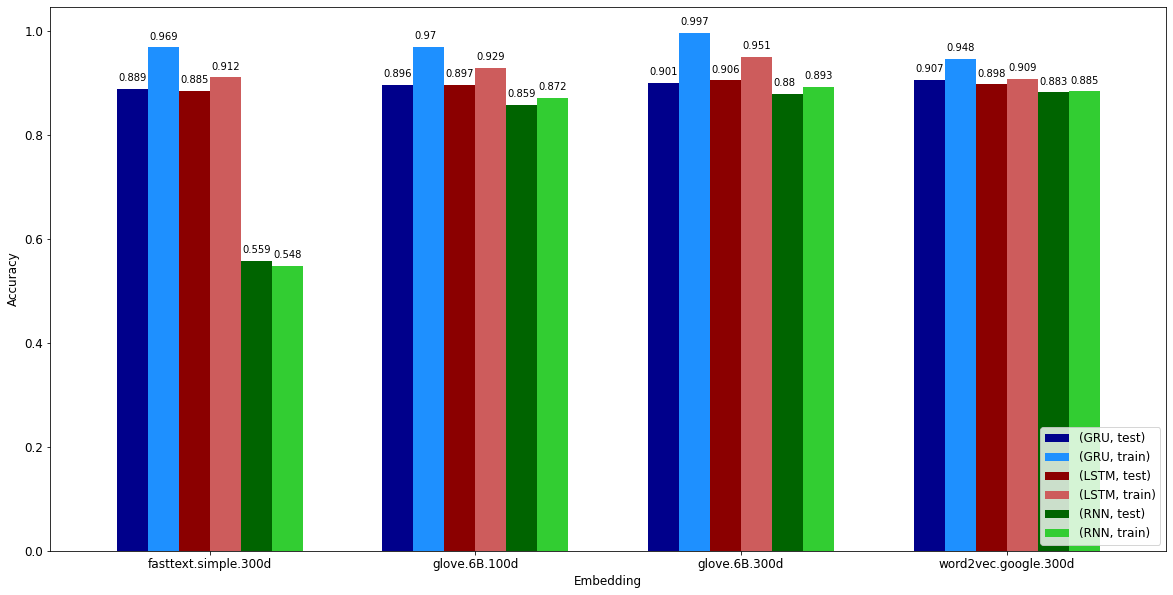

In [5]:
colors = ['darkblue', 'dodgerblue', 'darkred', 'indianred', 'darkgreen', 'limegreen']

df = filter_df(accuracies, {'dataset': 'IMDB', 'vocab_size': 50000, 'epoch': 10}).pivot(columns='type')
ax = df.plot.bar(figsize=(20, 10), fontsize=12, rot=0, width=0.7, color=colors)

ax.set_xlabel('Embedding', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.legend(fontsize=12, loc='lower right')

for p in ax.patches:
    ax.text(
        p.get_x() + 0.005,
        p.get_height() + .015,
        str(round(p.get_height(), 3)),
        color='black'
    )

### Convergence

In [6]:
losses = emb.pivot_table(index=['dataset', 'vocab_size', 'embedding', 'type', 'epoch'], columns='net', values='loss_mean').reset_index()
losses = losses.set_index('epoch')
losses.head()

net,dataset,vocab_size,embedding,type,GRU,LSTM,RNN
epoch,,,,,,,
1,IMDB,25000,fasttext.simple.300d,test,0.447992,0.522640,0.693316
2,IMDB,25000,fasttext.simple.300d,test,0.292628,0.394082,0.669434
3,IMDB,25000,fasttext.simple.300d,test,0.279250,0.330139,0.699103
4,IMDB,25000,fasttext.simple.300d,test,0.267186,0.358252,0.693182
5,IMDB,25000,fasttext.simple.300d,test,0.267720,0.282188,0.693967


#### IMDB

We observe similar behaviours to those of the previous section:

* GRU seems to overfit the training data more and sooner than LSTM;
* Word2Vec significantly reduces the overfitting;
* RNN is unable to learn from the FastText embedding.

Additionaly, we note that for GloVe and FastText, the convergence takes place around the 6<sup>th</sup> epoch. For Word2Vec, LSTM and RNN don't improve significantly after the 8<sup>th</sup> epoch, which motivated our limit of 10 epochs.

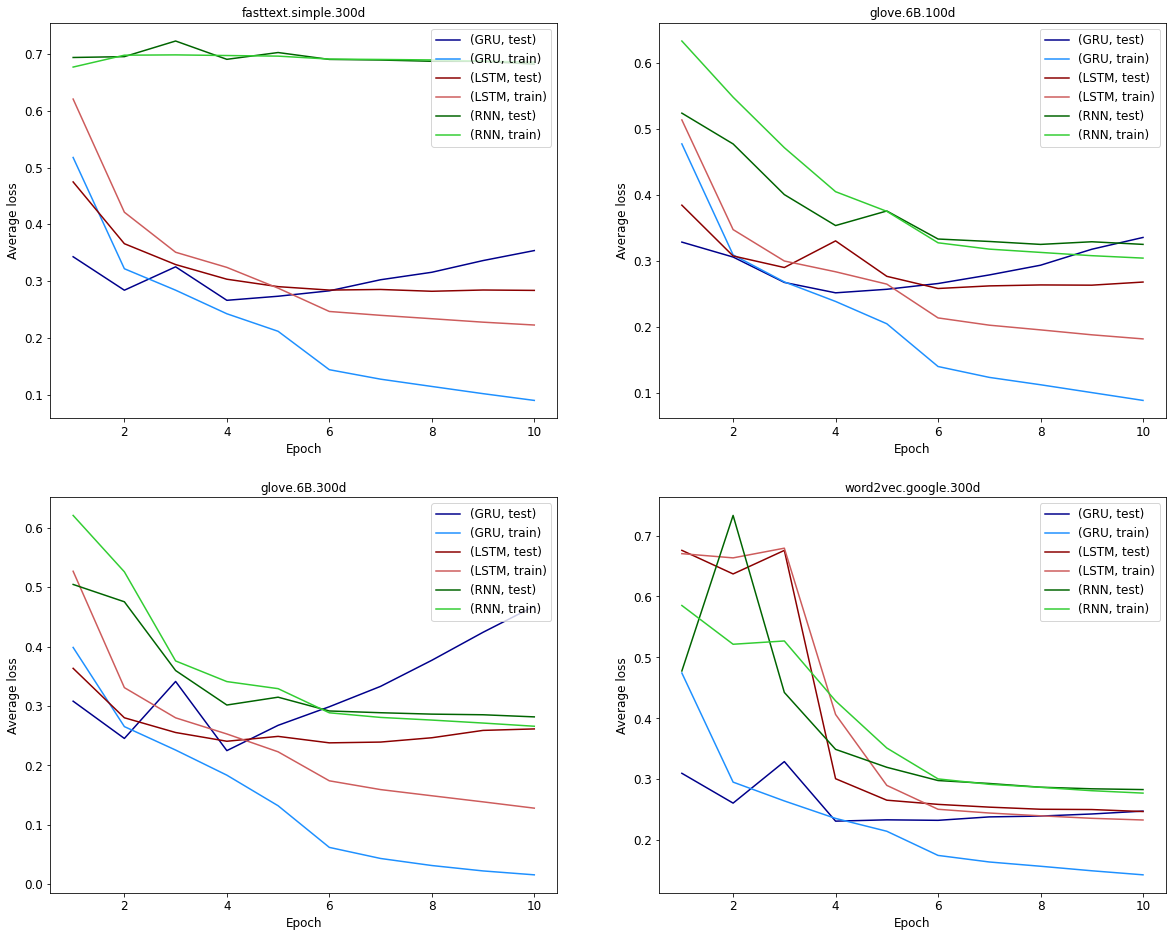

In [7]:
plt.figure(figsize=(20, 16))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

df = filter_df(losses, {'dataset': 'IMDB', 'vocab_size': 50000}).groupby('embedding')

for i, (name, content) in enumerate(df):
    ax = plt.subplot(2, 2, i + 1)
    content.pivot(columns='type').plot.line(fontsize=12, style=colors, ax=ax)

    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Average loss', fontsize=12)
    ax.set_title(name)
    ax.legend(fontsize=12, loc='upper right')

#### SST

In the case of SST, the overfitting arises much sooner (4<sup>th</sup> epoch). The smaller size of the training set combined with shorter training sentences could very likely explain this behaviour.

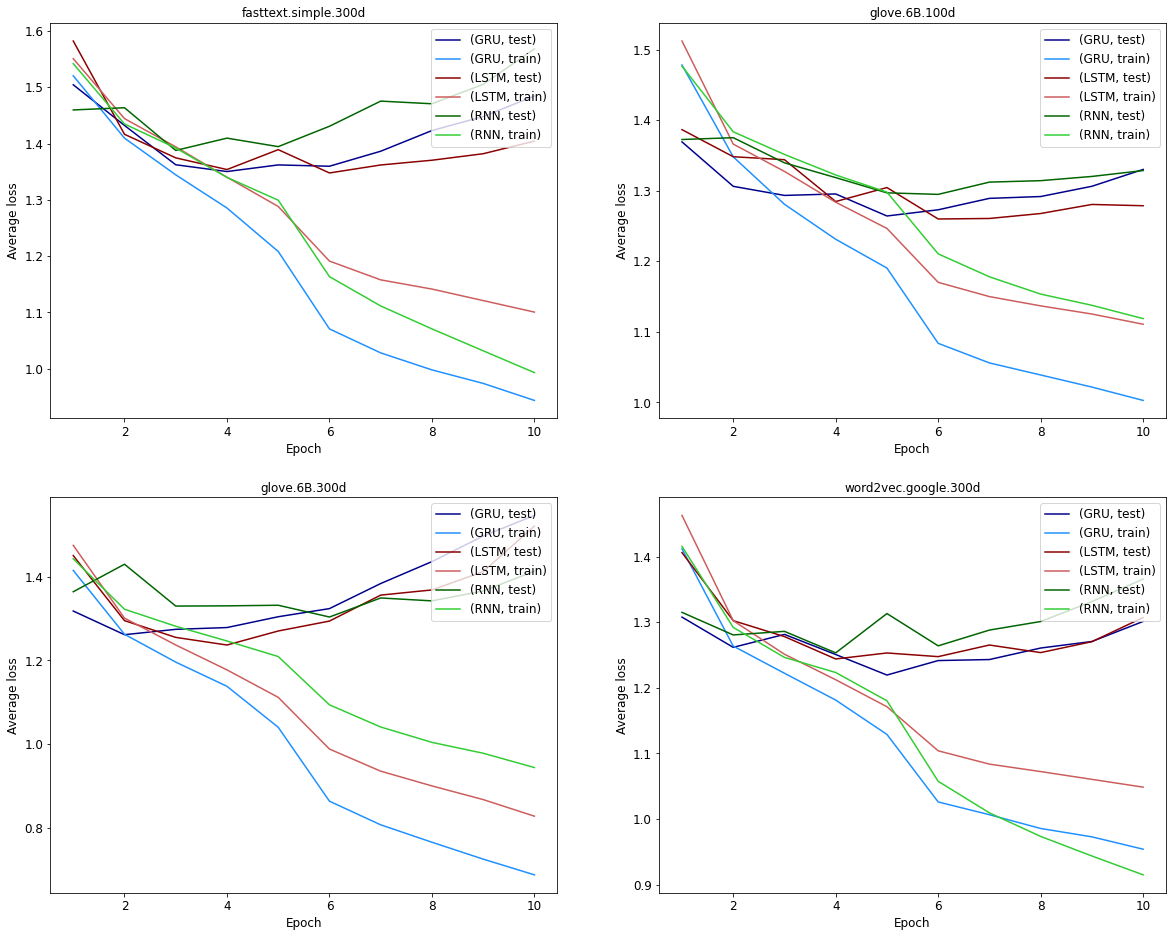

In [8]:
plt.figure(figsize=(20, 16))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

df = filter_df(losses, {'dataset': 'SST', 'vocab_size': 50000}).groupby('embedding')

for i, (name, content) in enumerate(df):
    ax = plt.subplot(2, 2, i + 1)
    content.pivot(columns='type').plot.line(fontsize=12, style=colors, ax=ax)

    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Average loss', fontsize=12)
    ax.set_title(name)
    ax.legend(fontsize=12, loc='upper right')

## Hyperparameters

In order to study the influence of the hyperparameters on the models, we have set the dataset (IMDB), the embedding (GloVe 300) and the size of the vocabulary (50000).

In the following, we use a statistic method called *clustering* to observe the impact of an individual parameter on a relevant metric. The technique consists in grouping (clustering) the individuals with respect to the parameter of interest and computing summary statistics (mean, std, etc.) of the metric within these groups. Since we tested every possible combination of the hyperparameters, the groups only differ by their value of the parameter of interest, and, therefore, the statistics are unbiaised.

In [9]:
hyper = pd.read_csv('../products/csv/hyperparameters.csv')
hyper['epoch'] += 1
hyper.head()

,dataset,vocab_size,embedding,net,hidden_size,num_layers,dropout,bidirectional,attention,type,epoch,time,speed,loss_mean,loss_std,precision,recall,f1-score,accuracy
0,IMDB,50000,glove.6B.300d,RNN,64,1,0.0,0,0,train,1,14.996659,26.072474,0.630445,0.062394,0.640440,0.64044,0.640440,0.64044
1,IMDB,50000,glove.6B.300d,RNN,64,1,0.0,0,0,test,1,10.071531,38.822299,0.630996,0.212115,0.711404,0.68080,0.668814,0.68080
2,IMDB,50000,glove.6B.300d,RNN,64,1,0.0,0,0,train,2,15.002599,26.062152,0.673065,0.055255,0.587756,0.58736,0.586894,0.58736
3,IMDB,50000,glove.6B.300d,RNN,64,1,0.0,0,0,test,2,9.810337,39.855921,0.654263,0.071096,0.617175,0.61048,0.604835,0.61048
4,IMDB,50000,glove.6B.300d,RNN,64,1,0.0,0,0,train,3,14.902292,26.237575,0.672856,0.045601,0.575610,0.57524,0.574719,0.57524


### Speed

Here are a few observations about model speed:

* RNN is faster than GRU and LSTM;
* Larger hidden vectors slows *slightly* the models;
* More layers slows *significantly* the models;
* Dropout doesn't affect the testing (inference) but slows the training, which is expected;
* Bidirectionality slows *significantly*  the models;
* Attention slows *very sightly* the models.

In [10]:
params = ['net', 'hidden_size', 'num_layers', 'dropout', 'bidirectional', 'attention']

impact(hyper, on='speed', of=params, const=['type'])

                speed                                          
                 mean       std       min     median        max
type  net                                                      
test  GRU   18.702517  6.308517  5.744259  20.208847  33.207515
      LSTM  17.890666  5.909960  8.249791  19.084782  29.093572
      RNN   20.901795  7.597608  7.306669  20.443074  39.855921
train GRU    9.706751  4.226621  2.620172   9.183385  20.636676
      LSTM   9.373479  4.410222  3.621646   8.766517  20.669226
      RNN   11.188257  5.458703  1.983761  10.478481  27.293610
--------------------------------------------------------------------------------
                       speed                                          
                        mean       std       min     median        max
type  hidden_size                                                     
test  64           20.715858  7.084776  8.863645  20.735719  39.855921
      256          17.614127  6.036176  5.744259  18.087593

### Accuracy

Here are a few observations about RNNs' accuracy:

* Larger hidden vectors reduces *significantly* the accuracy;
* More layers reduces *significantly* the accuracy;
* Dropout improves *slightly* the accuracy;
* Bidirectionality improves *significantly* the accuracy;
* Attention improves *very significantly*  the accuracy.

Concerning the hidden vector size and the number of layers, the reduction of accuracy in both testing and training means that the network did not finish learning after the 10 epochs.

In [11]:
params = ['hidden_size', 'num_layers', 'dropout', 'bidirectional', 'attention']

impact(filter_df(hyper, {'net': 'RNN', 'epoch': 10}), on='accuracy', of=params, const=['type'])

                   accuracy                                     
                       mean       std      min   median      max
type  hidden_size                                               
test  64           0.771182  0.097292  0.57832  0.75374  0.88620
      256          0.713087  0.128645  0.50000  0.73636  0.87712
train 64           0.794223  0.075848  0.70456  0.74702  0.90968
      256          0.730455  0.138747  0.50284  0.73210  0.91756
--------------------------------------------------------------------------------
                  accuracy                                     
                      mean       std      min   median      max
type  num_layers                                               
test  1           0.774900  0.104288  0.57744  0.80294  0.87712
      2           0.709370  0.121033  0.50000  0.73342  0.88620
train 1           0.797428  0.102541  0.60668  0.80010  0.91756
      2           0.727250  0.118453  0.50284  0.73610  0.90968
----------------

None of the hyperparameters seem to alter significantly LSTMs' accuracy.


In [12]:
impact(filter_df(hyper, {'net': 'LSTM', 'epoch': 10}), on='accuracy', of=params, const=['type'])

                   accuracy                                     
                       mean       std      min   median      max
type  hidden_size                                               
test  64           0.892670  0.007275  0.87428  0.89186  0.90504
      256          0.898655  0.005166  0.88784  0.90134  0.90416
train 64           0.912347  0.014957  0.88172  0.91216  0.94324
      256          0.937218  0.024587  0.89708  0.93124  0.97648
--------------------------------------------------------------------------------
                  accuracy                                     
                      mean       std      min   median      max
type  num_layers                                               
test  1           0.895070  0.005193  0.88864  0.89266  0.90400
      2           0.896255  0.008426  0.87428  0.89922  0.90504
train 1           0.927323  0.021843  0.89868  0.92110  0.96596
      2           0.922243  0.025831  0.88172  0.91648  0.97648
----------------

None of the hyperparameters seem to alter significantly GRUs' accuracy.

In [13]:
impact(filter_df(hyper, {'net': 'GRU', 'epoch': 10}), on='accuracy', of=params, const=['type'])

                   accuracy                                     
                       mean       std      min   median      max
type  hidden_size                                               
test  64           0.902055  0.001968  0.89876  0.90222  0.90564
      256          0.899815  0.003003  0.89548  0.90082  0.90508
train 64           0.949015  0.012799  0.93132  0.94686  0.97492
      256          0.985337  0.011082  0.96492  0.98284  0.99896
--------------------------------------------------------------------------------
                  accuracy                                     
                      mean       std      min   median      max
type  num_layers                                               
test  1           0.899587  0.002461  0.89548  0.90002  0.90328
      2           0.902282  0.002374  0.89556  0.90222  0.90564
train 1           0.963333  0.022366  0.93132  0.96360  0.99716
      2           0.971020  0.021413  0.94088  0.97560  0.99896
----------------

## Demonstration

100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.61it/s]


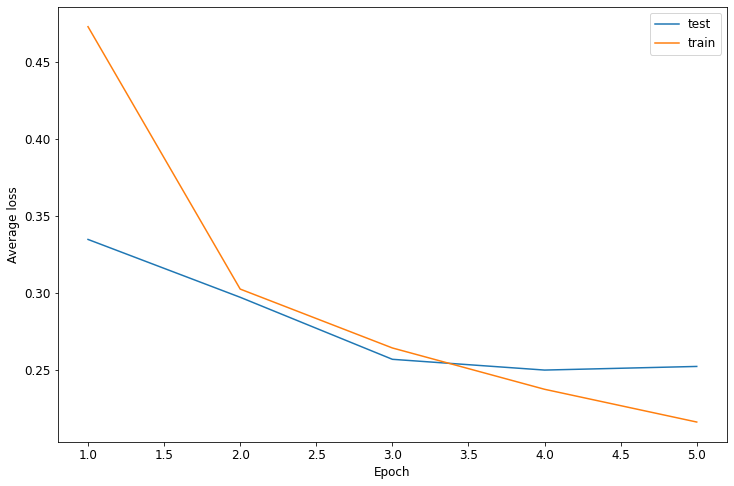

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model, labels, indexer, stats = train(
    output_file=None,
    dataset='IMDB',
    vocab_size=50000,
    embedding='glove.6B.300d', 
    net='GRU',
    epochs=5
)

stats['epoch'] += 1

ax = stats.pivot_table(index='epoch', columns='type', values='loss_mean').plot.line(figsize=(12, 8), fontsize=12)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Average loss', fontsize=12)
ax.legend(fontsize=12)

plt.show()

In [15]:
positive = 'I enjoyed watching this movie, especially the first half. However, the soundtrack is a bit slow.'
negative = 'That is, without a doubt, the worse movie I have ever seen. The dog was cute, though.'
neutral = 'I watched this movie at home.'

model.eval()

with torch.no_grad():
    for text in [positive, negative, neutral]:
        seq = indexer(text)

        inputs = torch.tensor([seq]).to(device)
        lengths = torch.tensor([len(seq)])

        outputs = model(inputs, lengths).cpu()
        prob = model.prediction(outputs).squeeze()
        pred = prob.argmax().item()

        print(f'"{text[:20]}..." is {labels[pred]} (probabilities: {prob.numpy()})')

"I enjoyed watching t..." is pos (probabilities: [0.09206408 0.9079359 ])
"That is, without a d..." is neg (probabilities: [0.74904203 0.25095797])
"I watched this movie..." is pos (probabilities: [0.43026862 0.56973135])
